# Modeling and Simulation in Python

Chapter 10 Example: Springy Pendulum

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# to switch from one to another, you have to select Kernel->Restart

%matplotlib notebook

from modsim import *

### Pendulum

This notebook solves the Spider-Man problem from spiderman.ipynb, demonstrating a different development process for physical simulations.

In pendulum_sympy, we derive the equations of motion for a springy pendulum without drag, yielding:

$ \ddot{x} = \frac{k length_{0} x}{m \sqrt{x^{2} + y^{2}}} - \frac{k x}{m} $

$ \ddot{y} = - g + \frac{k length_{0} y}{m \sqrt{x^{2} + y^{2}}} - \frac{k y}{m} $

We'll use the same conditions we saw in `spiderman.ipynb`

In [2]:
condition = Condition(g = 9.8,
                      m = 75,
                      area = 1,
                      rho = 1.2,
                      v_term = 60,
                      duration = 30,
                      length0 = 100,
                      angle = (270 - 45),
                      k = 20)

Now here's a version of `make_system` that takes a `Condition` object as a parameter.

`make_system` uses the given value of `v_term` to compute the drag coefficient `C_d`.

In [9]:
def make_system(condition):
    """Makes a System object for the given conditions.
    
    condition: Condition with height, g, m, diameter, 
               rho, v_term, and duration
    
    returns: System with init, g, m, rho, C_d, area, and ts
    """
    unpack(condition)
        
    theta = np.deg2rad(angle)
    x, y = pol2cart(theta, length0)
    P = Vector(x, y)
    V = Vector(0, 0)
    
    init = State(x=P.x, y=P.y, vx=V.x, vy=V.y)
    C_d = 2 * m * g / (rho * area * v_term**2)
    ts = linspace(0, duration, 501)
    
    
    return System(init=init, g=g, m=m, rho=rho,
                  C_d=C_d, area=area, length0=length0,
                  k=k, ts=ts)

Let's make a `System`

In [10]:
system = make_system(condition)
system

,value
init,x -70.71067811865477 dimensionless y -...
g,9.8
m,75
rho,1.2
C_d,0.340278
area,1
length0,100
k,20
ts,"[0.0, 0.06, 0.12, 0.18, 0.24, 0.3, 0.36, 0.42,..."


In [11]:
system.init

,value
x,-70.71067811865477 dimensionless
y,-70.71067811865474 dimensionless
vx,0 dimensionless
vy,0 dimensionless


To write the slope function, we can get the expressions for `ax` and `ay` directly from SymPy and plug them in.

In [32]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with length0, m, k
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    ax = k*length0*x/(m*sqrt(x**2 + y**2)) - k*x/m
    ay = -g + k*length0*y/(m*sqrt(x**2 + y**2)) - k*y/m

    return vx, vy, ax, ay

As always, let's test the slope function with the initial conditions.

In [33]:
slope_func(system.init, 0, system)

(<Quantity(0, 'dimensionless')>,
 <Quantity(0, 'dimensionless')>,
 <Quantity(0.0, 'dimensionless')>,
 <Quantity(-9.8, 'dimensionless')>)

And then run the simulation.

In [34]:
%time run_odeint(system, slope_func)

CPU times: user 84 ms, sys: 0 ns, total: 84 ms
Wall time: 83.6 ms


### Visualizing the results

We can extract the x and y components as `Series` objects.

In [35]:
xs = system.results.x
ys = system.results.y

The simplest way to visualize the results is to plot x and y as functions of time.

<IPython.core.display.Javascript object>


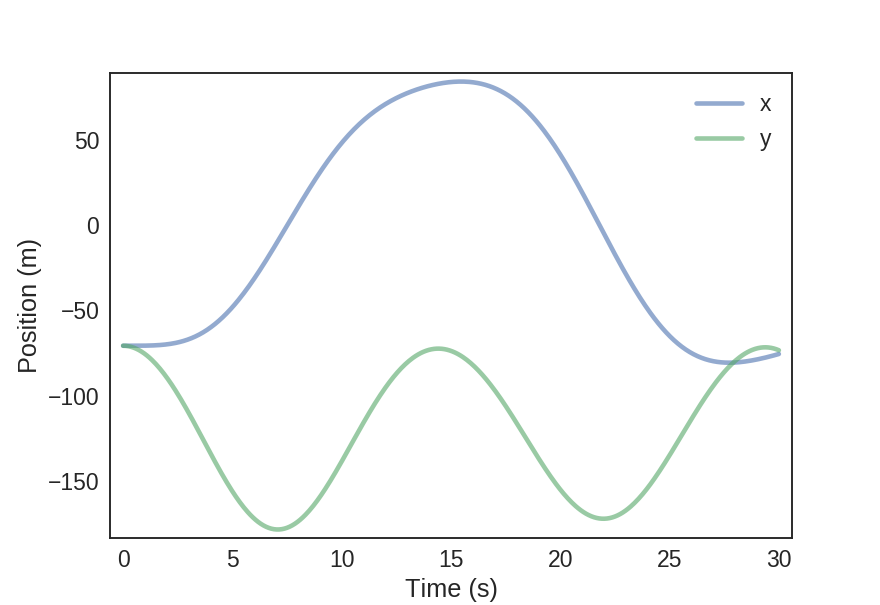

In [36]:
newfig()
plot(xs, label='x')
plot(ys, label='y')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

We can plot the velocities the same way.

In [37]:
vxs = system.results.vx
vys = system.results.vy

<IPython.core.display.Javascript object>


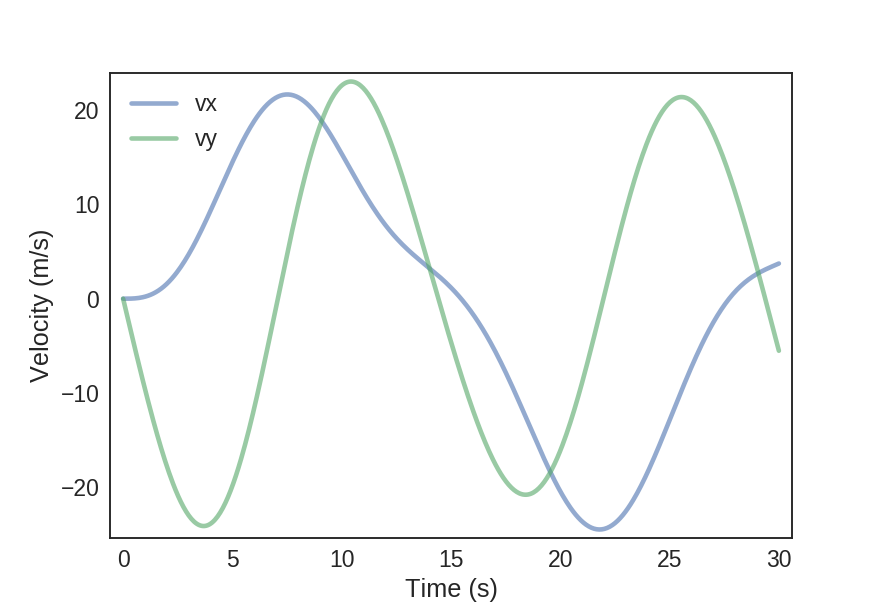

In [38]:
newfig()
plot(vxs, label='vx')
plot(vys, label='vy')

decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)')

Another way to visualize the results is to plot y versus x.  The result is the trajectory through the plane of motion.

<IPython.core.display.Javascript object>


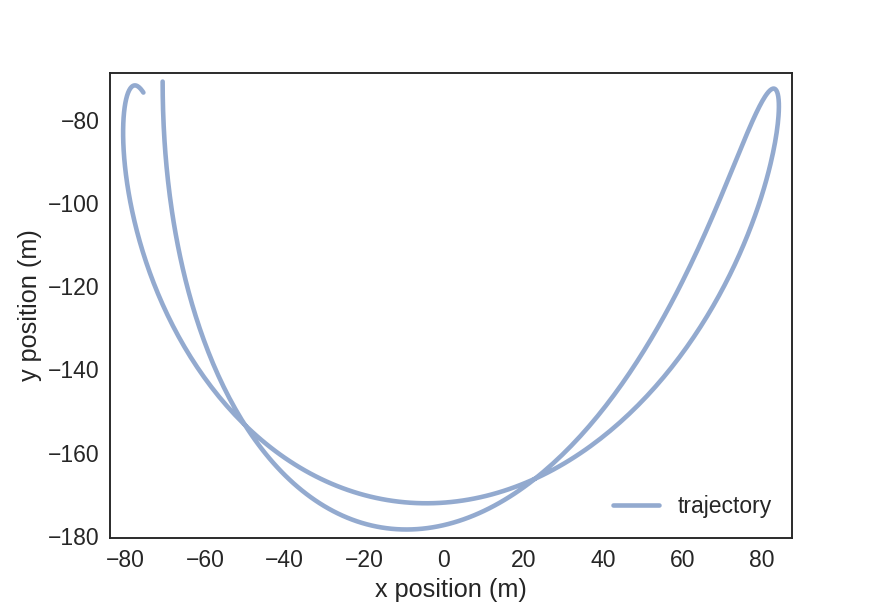

In [39]:
newfig()
plot(xs, ys, label='trajectory')

decorate(xlabel='x position (m)',
         ylabel='y position (m)')

We can also animate the trajectory.  If there's an error in the simulation, we can sometimes spot it by looking at animations.

<IPython.core.display.Javascript object>


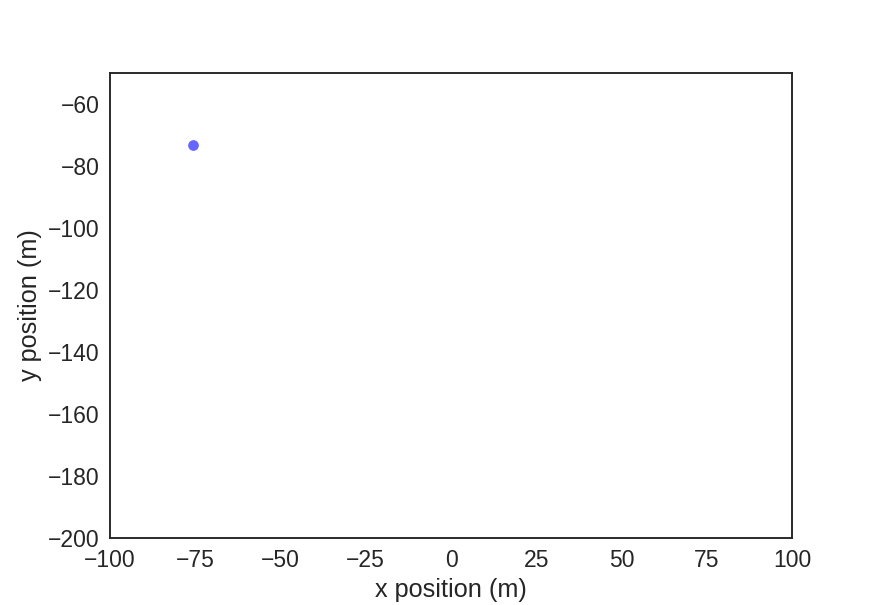

In [40]:
newfig()
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         xlim=[-100, 100],
         ylim=[-200, -50],
         legend=False)

for x, y in zip(xs, ys):
    plot(x, y, 'bo', update=True)
    sleep(0.01)

Here's a function that encapsulates that code and runs the animation in (approximately) real time.

In [21]:
def animate2d(xs, ys, speedup=1):
    """Animate the results of a projectile simulation.
    
    xs: x position as a function of time
    ys: y position as a function of time
    
    speedup: how much to divide `dt` by
    """
    # get the time intervals between elements
    ts = xs.index
    dts = np.diff(ts)
    dts = np.append(dts, 0)

    # decorate the plot
    newfig()
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=[xs.min(), xs.max()],
             ylim=[ys.min(), ys.max()],
             legend=False)

    # loop through the values
    for x, y, dt in zip(xs, ys, dts):
        plot(x, y, 'bo', update=True)
        sleep(dt / speedup)

<IPython.core.display.Javascript object>


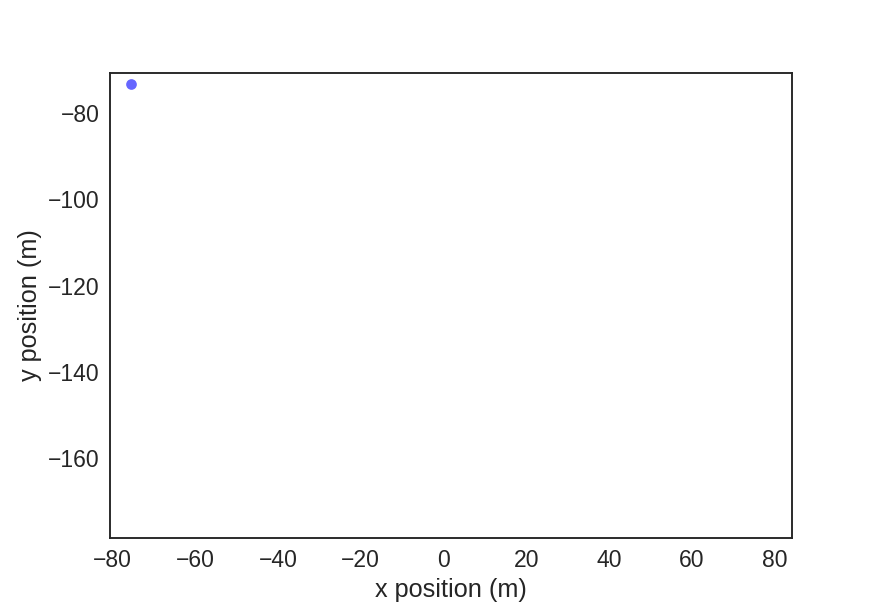

In [22]:
animate2d(system.results.x, system.results.y)